In [1]:
# - Imports
import warnings
warnings.filterwarnings('ignore')
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import os
from nengo_extras.plot_spikes import plot_spikes

In [2]:
def weight_init(shape):
    '''Convenience function for randomly initializing weights'''
    weights = np.random.uniform(-0.05, 0.05, size=shape)
    return weights

def generate_xor_sample(total_duration, dt, amplitude=1, use_smooth=True, plot=False):
    """
    Generates a temporal XOR signal
    """
    input_duration = 2/3*total_duration
    # Create a time base
    t = np.linspace(0,total_duration, int(total_duration/dt)+1)
    
    first_duration = np.random.uniform(low=input_duration/10, high=input_duration/4 )
    second_duration = np.random.uniform(low=input_duration/10, high=input_duration/4 )

    end_first = np.random.uniform(low=first_duration, high=2/3*input_duration-second_duration)
    start_first = end_first - first_duration

    start_second = np.random.uniform(low=end_first + 0.1, high=2/3*input_duration-second_duration) # At least 200 ms break
    end_second = start_second+second_duration

    data = np.zeros(int(total_duration/dt)+1)

    i1 = np.random.rand() > 0.5
    i2 = np.random.rand() > 0.5
    response = (((not i1) and i2) or (i1 and (not i2)))
    if(i1):
        a1 = 1
    else:
        a1 = -1
    if(i2):
        a2 = 1
    else:
        a2 = -1

    input_label = 0
    if(a1==1 and a2==1):
        input_label = 0
    elif(a1==1 and a2==-1):
        input_label = 1
    elif(a1==-1 and a2==1):
        input_label = 2
    else:
        input_label = 3

    data[(start_first <= t) & (t < end_first)] = a1
    data[(start_second <= t) & (t < end_second)] = a2

    if(use_smooth):
        sigma = 10
        w = (1/(sigma*np.sqrt(2*np.pi)))* np.exp(-((np.linspace(1,1000,int(1/dt))-500)**2)/(2*sigma**2))
        w = w / np.sum(w)
        data = amplitude*np.convolve(data, w, "same")
    else:
        data *= amplitude

    target = np.zeros(int(total_duration/dt)+1)
    if(response):
        ar = 1.0
    else:
        ar = -1.0
    
    target[int(1/dt*(end_second+0.05)):int(1/dt*(end_second))+int(1/dt*0.3)] = ar
    sigma = 20
    w = (1/(sigma*np.sqrt(2*np.pi)))* np.exp(-((np.linspace(1,1000,int(1/dt))-500)**2)/(2*sigma**2))
    w = w / np.sum(w)
    target = np.convolve(target, w, "same")
    target /= np.max(np.abs(target))

    if(plot):
        eps = 0.05
        fig = plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.plot(t, data)
        plt.ylim([-amplitude-eps, amplitude+eps])
        plt.subplot(122)
        plt.plot(t, target)
        plt.show()

    return (data[:int(total_duration/dt)], target[:int(total_duration/dt)], input_label)

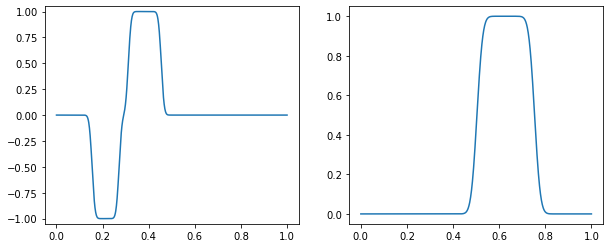

In [3]:
# - Check the input/target
_,_,_ = generate_xor_sample(1.0,dt=0.001,plot=True)

In [4]:
inp_dim = 1
out_dim = 1

n_neurons = 384
max_rate = 250
amplitude = 1 / max_rate
dt = 0.001
duration = 1.0

mem_tau = 0.05 # s
syn_tau = 0.07 # s

duration = 1.0 # s

# - Tau_rc is the membrane TC, tau_ref is the refractory period
lifs = nengo.LIF(tau_rc=mem_tau, tau_ref=0.00, amplitude=amplitude)


In [5]:
# - Network connectivity, only one recurrently connected ensemble
with nengo.Network() as net:
    net.config[nengo.Connection].synapse = nengo.synapses.Lowpass(tau=syn_tau)
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])

    inp = nengo.Node(np.zeros(inp_dim))
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=1, neuron_type=lifs)
    out = nengo.Node(size_in=out_dim)

    conn_a = nengo.Connection(
        inp, ens.neurons, transform=weight_init(shape=(n_neurons, inp_dim)))
    
    conn_rec = nengo.Connection(
        ens.neurons, ens.neurons, transform=weight_init(shape=(n_neurons, n_neurons)))

    conn_b = nengo.Connection(
        ens.neurons, out, transform=weight_init(shape=(out_dim, n_neurons)) / mem_tau)
    
    probe_out = nengo.Probe(out, synapse=0.01)
    probe_spikes = nengo.Probe(ens.neurons)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:00                                                 


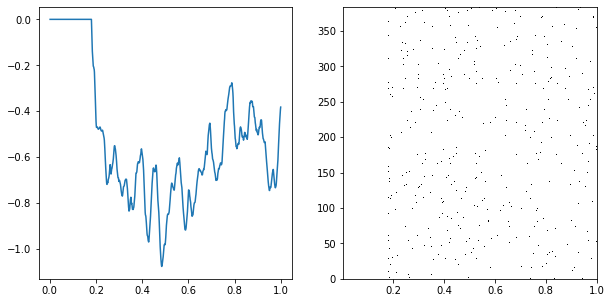

In [6]:
# - Pass a sample data point through the random network and plot the outputs
with nengo_dl.Simulator(net) as sim:
    # Run it for 1 second
    sample_xor_input, _, _ = generate_xor_sample(duration, dt=dt)
    # - Reshape to (num_batches, time_steps, num_dimensions)
    sample_xor_input = np.reshape(sample_xor_input, newshape=(1,len(sample_xor_input),1))
    sim.run(sample_xor_input.shape[1]*dt, data={inp: sample_xor_input})
    
    # - Do some plotting
    fig = plt.figure(figsize=(10,5))
    plt.subplot(121); plt.plot(sim.trange(), sim.data[probe_out])
    plt.subplot(122); plot_spikes(sim.trange(), sim.data[probe_spikes])
    plt.show()

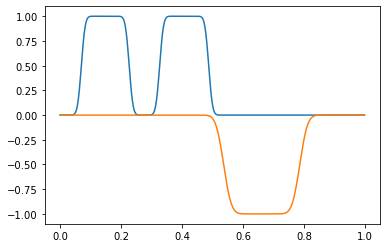

In [7]:
# - Do the training

# - Create training data set
N = 1000
T = int(duration / dt)
data = [generate_xor_sample(total_duration=duration, dt=dt, amplitude=1.0)[:2] for i in range(N)]
x = np.empty((N,T,inp_dim))
y = np.empty((N,T,out_dim))
for i in range(N):
    x[i,:,:] = np.reshape(data[i][0], newshape=(T,inp_dim))
    y[i,:,:] = np.reshape(data[i][1], newshape=(T,out_dim))
    
# - Inspect the data
plt.plot(np.arange(0,duration,dt),x[0,:,:]); plt.plot(np.arange(0,duration,dt),y[0,:,:])
plt.show()

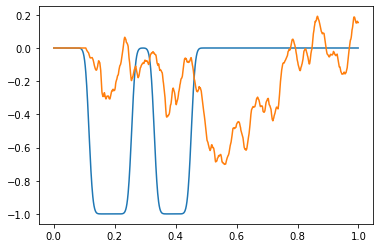

Epoch 200/200
1000/1000 [==============================] - 114s 114ms/sample - loss: 0.0126 - probe_loss: 0.0126


In [9]:
class PlotCallback(tf.keras.callbacks.Callback):
    def __init__(self,sim):
        self.sim = sim
    
    def on_epoch_begin(self, epoch, logs=None):
        if(epoch % 5 == 0):
            self.sim.save_params(path="Resources/trained_model")
        fig = plt.figure(figsize=(10,5))
        out_pred = self.sim.predict(x={inp: x[:50,:,:]})
        t = np.arange(0,duration,dt)
        for i in range(50):
            display.clear_output(wait=True)
            plt.clf()
            plt.plot(t, x[i,:,:]); plt.plot(t, out_pred[probe_out][i,:,:])
            plt.draw()
            plt.pause(0.001)
        

n_epochs = 200
minibatch_size = 50
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    mse = tf.keras.losses.MeanSquaredError()
    # adam = tf.keras.optimizers.Adam()
    # rmsprop = tf.keras.optimizers.RMSprop()
    sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
    if(os.path.exists("Resources/trained_model.npz")):
        sim.load_params("Resources/trained_model")
    
    sim.compile(loss={probe_out: mse}, optimizer=sgd)
    
    # - Fit the model
    sim.fit(x={inp: x}, y={probe_out: y}, epochs=n_epochs, callbacks=[PlotCallback(sim)])
    
    # - Save the simulation
    sim.save_params(path="Resources/trained_model")